# ISYE 6740 Project

Import necessary libraries

In [33]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter

In [374]:
sns.set(font_scale=1.0)

## Data

Load data, drop null values and display:

In [6]:
path_old = os.path.abspath('data')
path = 'C:\\Users\\megan\\Desktop\\ISYE_6740\\Project\data'
file_name = "final_data.csv"
df = pd.read_csv(path+"\\"+file_name)
df=df.dropna().reset_index(drop=True)
df.head()

In [15]:
df = pd.read_csv("final_data.csv")
df=df.dropna().reset_index(drop=True)

Create dummy variables for **IQ_AVG_BROKER_REC**, the only feature with text.

In [16]:
recc_dummy = pd.get_dummies(df['IQ_AVG_BROKER_REC'])
df=pd.concat([df,recc_dummy],axis=1)

Create the final analysis dataframe with all of the features and the response variable:

In [17]:
analysis_df=df[['IQ_TOTAL_DEBT_EQUITY',
       'IQ_TOTAL_DEBT_CAPITAL', 'IQ_EBITDA_INT', 'IQ_EBITDA_CAPEX_INT',
       'IQ_TOTAL_DEBT_EBITDA', 'IQ_RETURN_ASSETS', 'IQ_RETURN_CAPITAL',
       'IQ_RETURN_EQUITY', 'IQ_GROSS_MARGIN', 'IQ_EBITDA_MARGIN',
       'IQ_NI_MARGIN', 'IQ_CURRENT_RATIO', 'IQ_QUICK_RATIO',
       'IQ_DAYS_SALES_OUT', 'IQ_DAYS_INVENTORY_OUT', 'IQ_TOTAL_REV',
       'IQ_EBITDA', 'IQ_NI_CF', 'IQ_TOTAL_ASSETS', 'IQ_TOTAL_LIAB',
       'IQ_TOTAL_EQUITY', 'IQ_PBV', 'IQ_TEV_EBITDA', 'IQ_TEV_TOTAL_REV',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_EBITDA_1YR_ANN_GROWTH',
       'IQ_EBIT_1YR_ANN_GROWTH', 'IQ_NI_1YR_ANN_GROWTH',
       'IQ_EPS_1YR_ANN_GROWTH', 'IQ_AVG_BROKER_REC_NO',
       'IQ_PRICE_TARGET', 'IQ_EPS_EST', 'IQ_EST_EPS_GROWTH_5YR',
       'IQ_EPS_EST.1', 'IQ_REVENUE_EST', 'IQ_EBITDA_EST', 'IQ_EBIT_EST',
       'IQ_NI_EST', 'IQ_CFPS_EST', 'IQ_EST_NUM_BUY', 'IQ_EST_NUM_HOLD',
       'IQ_EST_NUM_SELL', 'IQ_EST_EPS_DIFF', 'IQ_EST_EPS_SURPRISE_PERCENT',
       'IQ_EST_REV_DIFF', 'IQ_EST_REV_SURPRISE_PERCENT','Buy', 'Hold', 'No Opinion', 'Outperform', 'Sell',
       'Underperform','Earnings_Move']]

Examine the number of observations that belong to the earnings_movers (1) and the non-earnings_movers (0):

In [13]:
analysis_df['Earnings_Move'].value_counts()

0    24965
1     1198
Name: Earnings_Move, dtype: int64

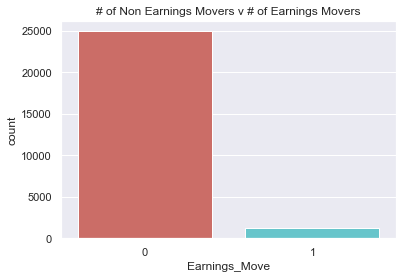

In [375]:
sns.countplot(x='Earnings_Move',data=analysis_df,palette='hls')
plt.title("# of Non Earnings Movers v # of Earnings Movers")
plt.show()

Separate the features from the response variable:

In [18]:
features_df = analysis_df[['IQ_TOTAL_DEBT_EQUITY', 'IQ_TOTAL_DEBT_CAPITAL', 'IQ_EBITDA_INT',
       'IQ_EBITDA_CAPEX_INT', 'IQ_TOTAL_DEBT_EBITDA', 'IQ_RETURN_ASSETS',
       'IQ_RETURN_CAPITAL', 'IQ_RETURN_EQUITY', 'IQ_GROSS_MARGIN',
       'IQ_EBITDA_MARGIN', 'IQ_NI_MARGIN', 'IQ_CURRENT_RATIO',
       'IQ_QUICK_RATIO', 'IQ_DAYS_SALES_OUT', 'IQ_DAYS_INVENTORY_OUT',
       'IQ_TOTAL_REV', 'IQ_EBITDA', 'IQ_NI_CF', 'IQ_TOTAL_ASSETS',
       'IQ_TOTAL_LIAB', 'IQ_TOTAL_EQUITY', 'IQ_PBV', 'IQ_TEV_EBITDA',
       'IQ_TEV_TOTAL_REV', 'IQ_TOTAL_REV_1YR_ANN_GROWTH',
       'IQ_EBITDA_1YR_ANN_GROWTH', 'IQ_EBIT_1YR_ANN_GROWTH',
       'IQ_NI_1YR_ANN_GROWTH', 'IQ_EPS_1YR_ANN_GROWTH',
       'IQ_AVG_BROKER_REC_NO', 'IQ_PRICE_TARGET', 'IQ_EPS_EST',
       'IQ_EST_EPS_GROWTH_5YR', 'IQ_EPS_EST.1', 'IQ_REVENUE_EST',
       'IQ_EBITDA_EST', 'IQ_EBIT_EST', 'IQ_NI_EST', 'IQ_CFPS_EST',
       'IQ_EST_NUM_BUY', 'IQ_EST_NUM_HOLD', 'IQ_EST_NUM_SELL',
       'IQ_EST_EPS_DIFF', 'IQ_EST_EPS_SURPRISE_PERCENT', 'IQ_EST_REV_DIFF',
       'IQ_EST_REV_SURPRISE_PERCENT','Buy', 'Hold', 'No Opinion',
       'Outperform', 'Sell', 'Underperform']]
y = analysis_df['Earnings_Move']

Create a train and test set to use for the models:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features_df, y, test_size=0.2, random_state=42,shuffle=True)

## Models

In [17]:
y_test.value_counts() #Keep this is mind when looking at the confusion matrices

0    4999
1     234
Name: Earnings_Move, dtype: int64

Run 3 typical classifiers on the imbalanced classification data:

In [8]:
def evaluate_model(model,X_train,y_train,X_test,y_test):
    m = model.fit(X_train,y_train)
    pred = m.predict(X_test)
    pred_prob = m.predict_proba(X_test)[:,1]
    accuracy = metrics.accuracy_score(y_test,pred)
    auc = metrics.roc_auc_score(y_test,pred)
    f1 = metrics.f1_score(y_test,pred)
    cm = confusion_matrix(y_test,pred)
    print("Accuracy : %f" % accuracy)
    print("AUC : %f" % accuracy)
    print("F1 Score : %f" % f1)
    return pred, accuracy,auc,f1,cm

In [9]:
def create_cm(title,cm):
    df_cm = pd.DataFrame(cm)
    ax= plt.subplot()
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',cmap="BuPu",ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix: '+title); 
    plt.show()

#### Logistic Regression

Accuracy : 0.953946
AUC : 0.953946
F1 Score : 0.000000


C:\Users\megan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


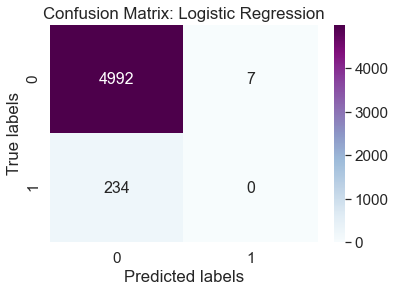

In [412]:
pred_lr,accuracy_lr,auc_lr,f1_lr,cm_lr=evaluate_model(LogisticRegression(random_state=42),X_train,y_train,X_test,y_test)
create_cm('Logistic Regression',cm_lr)

#### SVM

Accuracy : 0.955284
AUC : 0.955284
F1 Score : 0.000000


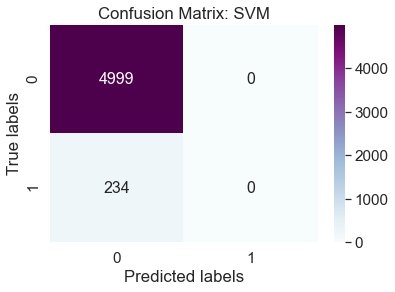

In [413]:
pred_svm,accuracy_svm,auc_svm,f1_svm,cm_svm=evaluate_model(SVC(probability=True),X_train,y_train,X_test,y_test)
create_cm('SVM',cm_svm)

#### RandomForest

Accuracy : 0.955284
AUC : 0.955284
F1 Score : 0.056452


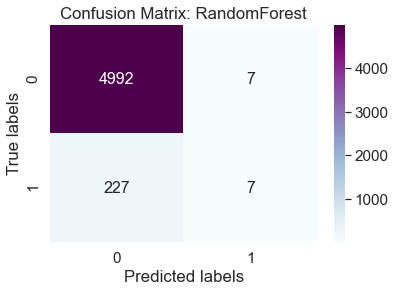

In [414]:
pred_rf,accuracy_rf,auc_rf,f1_rf,cm_rf=evaluate_model(RandomForestClassifier(random_state=42),X_train,y_train,X_test,y_test)
create_cm('RandomForest',cm_rf)

In [415]:
metrics.precision_score(y_test,pred_rf)

0.5

#### Summary Table

In [416]:
df_n=pd.DataFrame({'Model':['Logistic Regression','SVM','RandomForest'],
                              'Accuracy':[accuracy_lr,accuracy_svm,accuracy_rf],
                              'AUC':[auc_lr,auc_svm,auc_rf],'F1 Score':[f1_lr,f1_svm,f1_rf]})
df_n.style.format({
    'Accuracy': '{:,.3%}'.format,
    "AUC": '{:,.3%}'.format,
    "F1 Score": '{:,.3%}'.format,
    }).hide_index()

Model,Accuracy,AUC,F1 Score
Logistic Regression,95.395%,49.930%,0.000%
SVM,95.528%,50.000%,0.000%
RandomForest,95.528%,51.426%,5.645%


We can see the accuracy is for all three models is great, but the F1 score is very low for all three models. This means these models are very bad at predicting the earnings movers, which what we are interested in doing. We address this issue below.

### *Upsampling Minority, DownSampling Majority Class*

To achieve a more meaningful prediction, we will resample our dataset to have a more balanced proportion of classes. Using the SMOTE algorithm, we will also synthetically manufacture additional data points in the minority class.

In [36]:
def evaluate_model_with_resampling(model, X_train,y_train, X_test,y_test):
    #establish the resampling strategy
    over=SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline=Pipeline(steps)
    
    #evaluate new dataset/model using CV
    #cv = KFold(n_splits=10, random_state=42, shuffle=True)
    #accuracy = np.mean(cross_val_score(pipeline, X, Y, cv=cv, n_jobs=-1))
    #auc = np.mean(cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1))
    #f1 = np.mean(cross_val_score(pipeline, X, Y, scoring='f1', cv=cv, n_jobs=-1))
    d=pipeline.fit(X_train,y_train)
    pred=d.predict(X_test)
    pred_prob = d.predict_proba(X_test)[:,1]
    accuracy = metrics.accuracy_score(y_test,pred)
    auc = metrics.roc_auc_score(y_test,pred)
    f1 = metrics.f1_score(y_test,pred)
    cm = confusion_matrix(y_test,pred)
    print("Accuracy : %f" % accuracy)
    print("AUC : %f" % auc)
    print("F1 Score : %f" % f1)
    return accuracy,auc,f1,cm
    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy : 0.875024
AUC : 0.567975
F1 Score : 0.141732


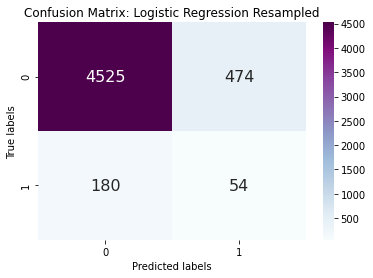

In [37]:
#Logistic Regression:
accuracy_lrs,auc_lrs,f1_lrs,cm_lrs = evaluate_model_with_resampling(LogisticRegression(random_state=42), X_train, y_train, X_test,y_test)
create_cm('Logistic Regression Resampled',cm_lrs)

Accuracy : 0.955284
AUC : 0.500000
F1 Score : 0.000000


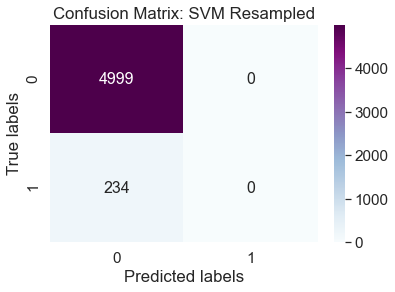

In [435]:
#Support Vector Machine:
accuracy_svms, auc_svms, f1_svms,cm_svms = evaluate_model_with_resampling(SVC(probability=True), X_train, y_train, X_test,y_test)
create_cm('SVM Resampled',cm_svms)

Accuracy : 0.905026
AUC : 0.661074
F1 Score : 0.270191


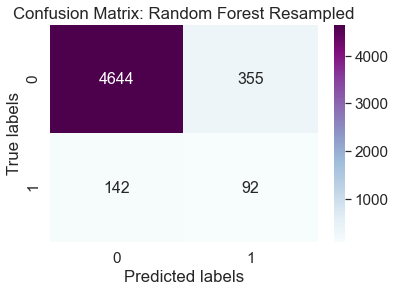

In [438]:
#Random Forest:
accuracy_rfs, auc_rfs,f1_rfs,cm_rfs = evaluate_model_with_resampling(RandomForestClassifier(random_state=42), X_train, y_train, X_test,y_test)
create_cm('Random Forest Resampled',cm_rfs)

#### Summary Table

In [439]:
df_s=pd.DataFrame({'Model':['Logistic Regression','SVM','RandomForest'],
                              'Accuracy':[accuracy_lrs,accuracy_svms,accuracy_rfs],
                              'AUC':[auc_lrs,auc_svms,auc_rfs],'F1 Score':[f1_lrs,f1_svms,f1_rfs]})
df_s.style.format({
    'Accuracy': '{:,.3%}'.format,
    "AUC": '{:,.3%}'.format,
    "F1 Score": '{:,.3%}'.format,
    }).hide_index()

Model,Accuracy,AUC,F1 Score
Logistic Regression,89.394%,56.158%,14.219%
SVM,95.528%,50.000%,0.000%
RandomForest,90.503%,66.107%,27.019%


The accuracy scores are a little lower for Logistic Regression and RandForest, but SVM is barely changed. There are significantly better F1 scores for Logistic Regression and RandomForest. 

### *XGBoost*

We chose to explore and tune an XGBboost model.

Below is a function that will help in the tuning process. I referenced https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for this code.

In [381]:
def modelfit(alg, dtrain, dtest,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Earnings_Move'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='aucpr', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print("Number of estimators: %f" %cvresult.shape[0])
        #print("CV mean %f" %cvresult.mean_)
    
    #Fit the algorithm on the train data
    alg.fit(dtrain[predictors], dtrain['Earnings_Move'],eval_metric='aucpr')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Earnings_Move'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Earnings_Move'], dtrain_predprob))
    print("F1 Score (Train): %f" % f1_score(dtrain['Earnings_Move'], dtrain_predictions))
    print("AUCPR (Train): %f" % metrics.average_precision_score(dtrain['Earnings_Move'], dtrain_predprob))
                      
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances',fontsize=8)
    plt.ylabel('Feature Importance Score')
    
        
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report Test")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtest['Earnings_Move'].values, dtest_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['Earnings_Move'], dtest_predprob))
    print("F1 Score (Test): %f" % f1_score(dtest['Earnings_Move'], dtest_predictions))
    print("AUCPR (Test): %f" % metrics.average_precision_score(dtest['Earnings_Move'], dtest_predprob))
    
    
    return dtest_predictions,dtest_predprob
    

Create train/test dataframes and specify predictor columns:

In [273]:
dtrain = pd.concat([X_train,y_train],axis=1)
dtest = pd.concat([X_test,y_test],axis=1)
predictors = ['IQ_TOTAL_DEBT_EQUITY', 'IQ_TOTAL_DEBT_CAPITAL', 'IQ_EBITDA_INT',
       'IQ_EBITDA_CAPEX_INT', 'IQ_TOTAL_DEBT_EBITDA', 'IQ_RETURN_ASSETS',
       'IQ_RETURN_CAPITAL', 'IQ_RETURN_EQUITY', 'IQ_GROSS_MARGIN',
       'IQ_EBITDA_MARGIN', 'IQ_NI_MARGIN', 'IQ_CURRENT_RATIO',
       'IQ_QUICK_RATIO', 'IQ_DAYS_SALES_OUT', 'IQ_DAYS_INVENTORY_OUT',
       'IQ_TOTAL_REV', 'IQ_EBITDA', 'IQ_NI_CF', 'IQ_TOTAL_ASSETS',
       'IQ_TOTAL_LIAB', 'IQ_TOTAL_EQUITY', 'IQ_PBV', 'IQ_TEV_EBITDA',
       'IQ_TEV_TOTAL_REV', 'IQ_TOTAL_REV_1YR_ANN_GROWTH',
       'IQ_EBITDA_1YR_ANN_GROWTH', 'IQ_EBIT_1YR_ANN_GROWTH',
       'IQ_NI_1YR_ANN_GROWTH', 'IQ_EPS_1YR_ANN_GROWTH',
       'IQ_AVG_BROKER_REC_NO', 'IQ_PRICE_TARGET', 'IQ_EPS_EST',
       'IQ_EST_EPS_GROWTH_5YR', 'IQ_EPS_EST.1', 'IQ_REVENUE_EST',
       'IQ_EBITDA_EST', 'IQ_EBIT_EST', 'IQ_NI_EST', 'IQ_CFPS_EST',
       'IQ_EST_NUM_BUY', 'IQ_EST_NUM_HOLD', 'IQ_EST_NUM_SELL',
       'IQ_EST_EPS_DIFF', 'IQ_EST_EPS_SURPRISE_PERCENT', 'IQ_EST_REV_DIFF',
       'IQ_EST_REV_SURPRISE_PERCENT','Buy', 'Hold', 'No Opinion',
       'Outperform', 'Sell', 'Underperform']

Create a generic XGBoost model and cross validate it to get the right number of estimators to tune with:

Number of estimators: 53.000000

Model Report
Accuracy : 0.958
AUC Score (Train): 0.938611
F1 Score (Train): 0.183673
AUCPR (Train): 0.537667

Model Report Test
Accuracy : 0.9553
AUC Score (Test): 0.825843
F1 Score (Test): 0.078740
AUCPR (Test): 0.222884


(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0.00593041, 0.12277371, 0.02257937, ..., 0.01171178, 0.01825077,
        0.02530169], dtype=float32))

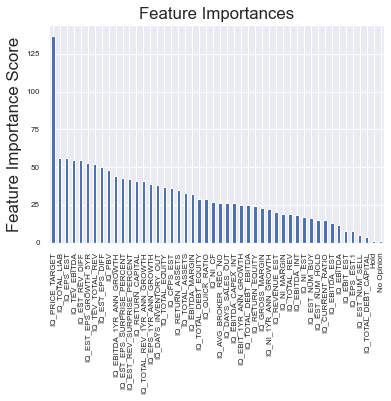

In [358]:
xgb1 = xgb.XGBClassifier(
 eta =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
modelfit(xgb1, dtrain, dtest, predictors)

#### Tune min_child_weight and max_depth

**max_depth** is the maximum number of nodes allowed from the root to the farthest leaf of a tree
and **min_child_weight** is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller **min_child_weight** allows the algorithm to create children that correspond to fewer samples, allowing for more complex trees, but more likely to overfit. It is a bias vs. variance tradeoff.

In [223]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(eta =0.1, n_estimators=38, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
param_grid = param_test1, scoring='f1',n_jobs=-1,iid=False, cv=5,verbose=1)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   38.9s finished
C:\Users\megan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, eta=0.1, max_depth=5,
                                     n_estimators=38, nthread=4, seed=42,
                                     subsample=0.8),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1', verbose=1)

#### Tune gamma

A node is split only when the resulting split gives a positive reduction in the loss function. **gamma** specifies the minimum loss reduction required to make a split.

In [225]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)],
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( eta =0.1, n_estimators=38, max_depth=7,
min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
param_grid = param_test3, scoring='f1',n_jobs=-1,iid=False, cv=5,verbose=1)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.2s finished
C:\Users\megan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.08373428673441834)

Number of estimators: 55.000000

Model Report
Accuracy : 0.9664
AUC Score (Train): 0.979099
F1 Score (Train): 0.430421
AUCPR (Train): 0.796682

Model Report Test
Accuracy : 0.9545
AUC Score (Test): 0.826034
F1 Score (Test): 0.091603
AUCPR (Test): 0.213273


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

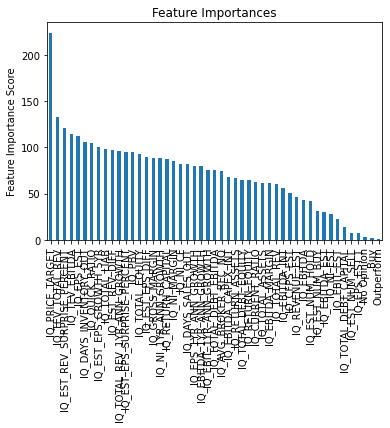

In [275]:
xgb1 = xgb.XGBClassifier(
 eta =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
modelfit(xgb1, dtrain, dtest, predictors)

#### Tune subsample and colsample_bytree

**subsample** corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
**colsample_bytree** corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

In [227]:
param_test4 = {
  'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(eta =0.1, n_estimators=54, max_depth=7,
min_child_weight=3, gamma=.4, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
param_grid = param_test4, scoring='f1',n_jobs=-1,iid=False, cv=5,verbose=1)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
C:\Users\megan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.08373428673441834)

#### Tune scale_pos_weight

Weights positive responses more heavily in the algorithm

In [228]:
param_test5 = {
  'scale_pos_weight': np.arange(0,110,10)
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=54, max_depth=7,
min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.9,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
param_grid = param_test5, scoring='f1',n_jobs=-1,iid=False, cv=5,verbose=1)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.0min finished
C:\Users\megan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'scale_pos_weight': 10}, 0.29872639942111456)

#### Tune alpha and lambda

Regularization constants

In [229]:
param_test6 = {
  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
    
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=54, max_depth=7,
min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.9,
objective= 'binary:logistic', nthread=4, scale_pos_weight=10, seed=42), 
param_grid = param_test6, scoring='f1',n_jobs=-1,iid=False, cv=5,verbose=1)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.8min finished
C:\Users\megan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 1, 'reg_lambda': 100}, 0.30875354309004577)

#### ETA

**eta** is the learning rate, corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step. We lower the learning rate to decrease overfitting. A lower learning rate requires more boosting rounds, which takes more time to train.

#### Final XGBoost Model


Model Report
Accuracy : 0.9497
AUC Score (Train): 0.982443
F1 Score (Train): 0.629055
AUCPR (Train): 0.718176

Model Report Test
Accuracy : 0.9163
AUC Score (Test): 0.837408
F1 Score (Test): 0.293548
AUCPR (Test): 0.240575


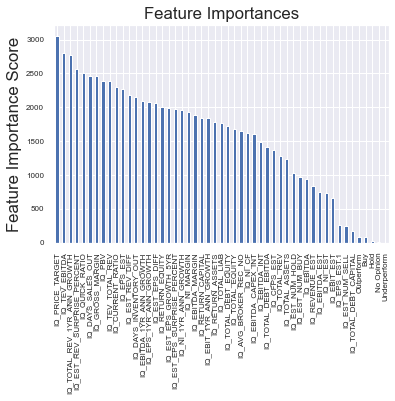

In [382]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.9,
 reg_alpha=1,
    reg_lambda=100,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=10,
 seed=42)
pred,pred_prob=modelfit(xgb4, dtrain, dtest,predictors, useTrainCV=False)
cm=confusion_matrix(y_test,pred)

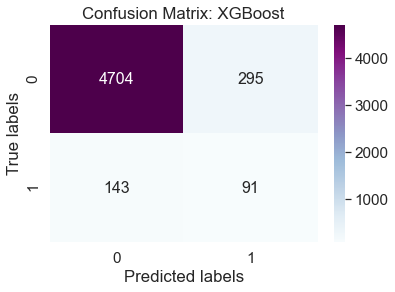

In [354]:
create_cm('XGBoost',cm)

## Final Summary Table of all 4 Models

In [444]:
accuracy_xgb = metrics.accuracy_score(y_test,pred)
#recall = metrics.recall_score(y_test,pred)
#avg_precision = metrics.average_precision_score(y_test,pred)
#precision = metrics.precision_score(y_test,pred)
f_1_xgb = metrics.f1_score(y_test,pred)
roc_auc_xgb=roc_auc_score(y_test, pred_prob)
final_results = pd.DataFrame({'Model':['XGBoost','Logistic Regression Resampled','SVM Resampled','RandomForest Resampled'],
                              'Accuracy':[accuracy_xgb,accuracy_lrs,accuracy_svms,accuracy_rfs],
                              'AUC':[roc_auc_xgb,auc_lrs,auc_svms,auc_rfs],'F1 Score':[f_1_xgb,f1_lrs,f1_svms,f1_rfs]})
final_results.style.format({
    'Accuracy': '{:,.3%}'.format,
    "AUC": '{:,.3%}'.format,
    "F1 Score": '{:,.3%}'.format,
    }).hide_index()

Model,Accuracy,AUC,F1 Score
XGBoost,91.630%,83.741%,29.355%
Logistic Regression Resampled,89.394%,56.158%,14.219%
SVM Resampled,95.528%,50.000%,0.000%
RandomForest Resampled,90.503%,66.107%,27.019%


We see XGBoost has the best results for this data.